In [108]:
#Load all necessary packages
library(gridExtra)
library(data.table)
library(rvest)
library(xml2)
library(stringr)
library(tidygeocoder)
library(plotly)
library(rjson)
library(ggplot2)
library(dplyr)

In [109]:
#To scrap info on postal codes, boroughs and neighbourhoods in Toronto, Canada from a url
data <- read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
body_nodes <- data %>% html_node('tbody') %>% html_children()

#extract information from node <tr> for list of postal codes, boroughs and neighbourhoods
list <- data %>% rvest::html_nodes('tbody') %>%
  xml2::xml_find_all("//tr") %>% rvest::html_text()

In [110]:
#To tidy up vectors
list <- list[2:185] #to remove the first row in the vector
postal_codes <- substr(list, 1, 3) #To capture only the postal codes
boroughs <- sub(".*\n\n *(.*?) *\n\n.*", "\\1", list) #to capture list of boroughs using regex.
neighbourhoods <- sub(".*\n\n *(.*?) *\n*", "\\2", list) #to capture list of neighbourhoods using regex.

In [111]:
#to create one dataframe
table_of_postal_codes <- data.table(Postal.Code = postal_codes, Borough=boroughs, Neighbourhood=neighbourhoods, stringsAsFactors = FALSE)

#to remove all rows with Not assigned in column Borough
table_of_postal_codes <- table_of_postal_codes[1:180]
table_of_postal_codes <- table_of_postal_codes[!(table_of_postal_codes$Borough == 'Not assigned')]

#to find the shape of the dataframe
str(table_of_postal_codes)


Classes 'data.table' and 'data.frame':	103 obs. of  3 variables:
 $ Postal.Code  : chr  "M3A" "M4A" "M5A" "M6A" ...
 $ Borough      : chr  "North York" "North York" "Downtown Toronto" "North York" ...
 $ Neighbourhood: chr  "Parkwoods\n" "Victoria Village\n" "Regent Park, Harbourfront\n" "Lawrence Manor, Lawrence Heights\n" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [112]:
#to see the summary of the dataframe
summary(table_of_postal_codes)

 Postal.Code          Borough          Neighbourhood     
 Length:103         Length:103         Length:103        
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  

In [113]:
#to view the first ten rows of the dataframe
head(table_of_postal_codes, 10)

Postal.Code,Borough,Neighbourhood
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
M1B,Scarborough,"Malvern, Rouge"
M3B,North York,Don Mills
M4B,East York,"Parkview Hill, Woodbine Gardens"
M5B,Downtown Toronto,"Garden District, Ryerson"


In [114]:
#to view the last ten rows of the dataframe
tail(table_of_postal_codes, 10)

Postal.Code,Borough,Neighbourhood
M8W,Etobicoke,"Alderwood, Long Branch"
M9W,Etobicoke,"Northwest, West Humber - Clairville"
M1X,Scarborough,Upper Rouge
M4X,Downtown Toronto,"St. James Town, Cabbagetown"
M5X,Downtown Toronto,"First Canadian Place, Underground city"
M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
M4Y,Downtown Toronto,Church and Wellesley
M7Y,East Toronto,"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto"
M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East"
M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West"


In [115]:
# to read the geospatial coordinates
geospatial <- read.csv('Geospatial_Coordinates.csv')
#to merge both dataframes
full_data <- merge(x=table_of_postal_codes,y=geospatial,by="Postal.Code")

In [116]:
head(full_data, 10)

Postal.Code,Borough,Neighbourhood,Latitude,Longitude
M1B,Scarborough,"Malvern, Rouge",43.80669,-79.19435
M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78454,-79.16050
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76357,-79.18871
M1G,Scarborough,Woburn,43.77099,-79.21692
M1H,Scarborough,Cedarbrae,43.77314,-79.23948
M1J,Scarborough,Scarborough Village,43.74473,-79.23948
M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.72793,-79.26203
M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.71111,-79.28458
M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.71632,-79.23948
M1N,Scarborough,"Birch Cliff, Cliffside West",43.69266,-79.26485


#### Map observation
It would be interesting to see the proximities between and amongst boroughs.

In [117]:
lat <- full_data$Latitude
long <- full_data$Longitude
bbox <- make_bbox(long,lat,f=0.1)
ontario <- get_map(bbox,maptype="toner-lite",source="stamen")

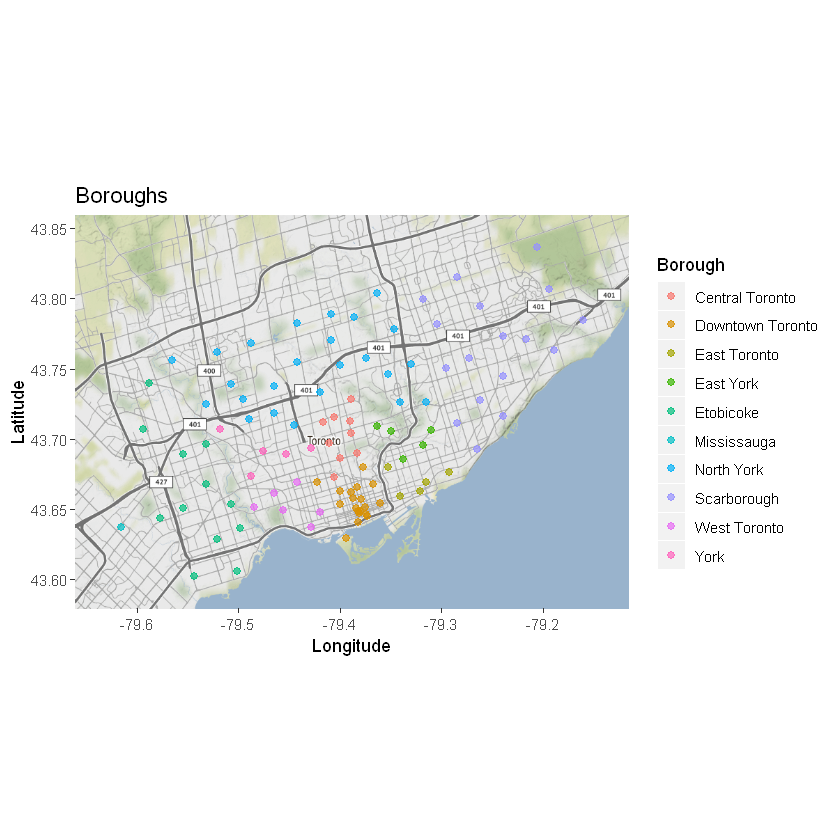

In [118]:
ggmap(ontario) + geom_point(data = full_data, 
           aes(Longitude,Latitude,color=Borough),size=2,alpha=0.7) +
           labs(x = "Longitude", y = "Latitude",
           title="Boroughs", color = "Borough");

The second map highlights the spread of neighbourhood within Scarborough.

In [119]:
Scarborough <- filter(full_data, Borough == 'Scarborough')
head(Scarborough, 3)

Postal.Code,Borough,Neighbourhood,Latitude,Longitude
M1B,Scarborough,"Malvern, Rouge",43.80669,-79.19435
M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78454,-79.16050
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76357,-79.18871


In [120]:
lat <- Scarborough$Latitude
long <- Scarborough$Longitude
bbox <- make_bbox(long,lat,f=0.1)
scarborough <- get_map(bbox,maptype="toner-lite",source="stamen");

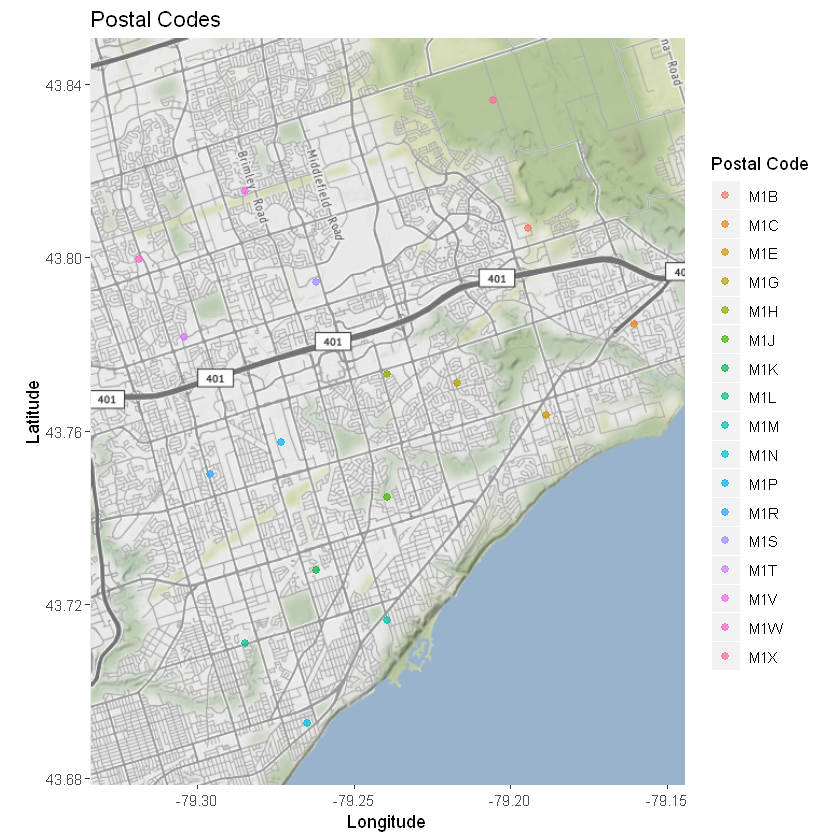

In [121]:
ggmap(scarborough) + geom_point(data = Scarborough, 
           aes(Longitude,Latitude,color=Postal.Code),size=2,alpha=0.7) +
           labs(x = "Longitude", y = "Latitude",
           title="Postal Codes", color = "Postal Code");